In [2]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
#from fancyimpute import KNN
import knnimpute
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance

In [3]:
train_data = pd.read_csv('data/titanic_train.csv')
print(f'Number of observations {train_data.shape[0]}, number of features {train_data.shape[1]}')
print(train_data.columns)

Number of observations 891, number of features 12
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


             Ntot  No. NA  NA Frac.
PassengerId   891       0  0.000000
Survived      891       0  0.000000
Pclass        891       0  0.000000
Name          891       0  0.000000
Sex           891       0  0.000000
Age           714     177  0.198653
SibSp         891       0  0.000000
Parch         891       0  0.000000
Ticket        891       0  0.000000
Fare          891       0  0.000000
Cabin         204     687  0.771044
Embarked      889       2  0.002245


Duplicate records (wrt PassengerId) 0


[]

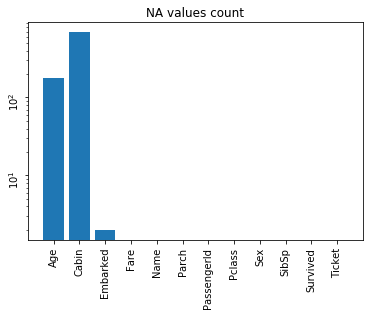

In [4]:
# Are there any missing values? At what fraction
miss_vals = pd.concat([train_data.count(), train_data.isnull().sum(), train_data.isnull().sum()/train_data.shape[0]], axis=1)
miss_vals.columns = ['Ntot', 'No. NA', 'NA Frac.']
print(miss_vals)
print('\n')
print(f'Duplicate records (wrt PassengerId) {train_data.PassengerId.duplicated().sum()}')
fig, axs = plt.subplots(1,1)
axs.bar(miss_vals.index, height=miss_vals['No. NA'])
axs.set_title('NA values count')
axs.tick_params(rotation=90)
axs.semilogy()

In [5]:
# PassengerId will be our index
train_data.set_index('PassengerId', inplace=True, drop=True)

In [6]:
# Check cardinality of int and object values
for k, val in train_data.dtypes.iteritems():
    if val == 'float64':
        continue
    # Ticket has high cardinality
    if k == 'Ticket' or k == 'Name':
        continue
    print(f'{k} has {train_data[k].unique().shape[0]} values')

Survived has 2 values
Pclass has 3 values
Sex has 2 values
SibSp has 7 values
Parch has 7 values
Cabin has 148 values
Embarked has 4 values


         Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200


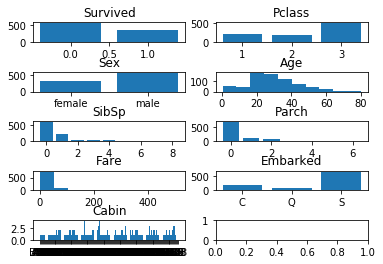

Survived ratio
0    0.616162
1    0.383838
Name: Survived, dtype: float64
train data set is decently balanced


In [7]:
# Check if there's outliers/non-sensical values
print(train_data.describe())

# Do some exploratory plots
fig, axs = plt.subplots(5,2)
axs[0,0].bar(train_data['Survived'].value_counts().index, height=train_data['Survived'].value_counts())
axs[0,0].set_title('Survived')
axs[0,1].bar(train_data['Pclass'].value_counts().index, height=train_data['Pclass'].value_counts())
axs[0,1].set_title('Pclass')
axs[1,0].bar(train_data['Sex'].value_counts().index, height=train_data['Sex'].value_counts())
axs[1,0].set_title('Sex')
axs[1,1].hist(train_data['Age'].dropna())
axs[1,1].set_title('Age')
axs[2,0].bar(train_data['SibSp'].value_counts().index, height=train_data['SibSp'].value_counts())
axs[2,0].set_title('SibSp')
axs[2,1].bar(train_data['Parch'].value_counts().index, height=train_data['Parch'].value_counts())
axs[2,1].set_title('Parch')
axs[3,0].hist(train_data['Fare'])
axs[3,0].set_title('Fare')
axs[3,1].bar(train_data['Embarked'].value_counts().index, height=train_data['Embarked'].value_counts())
axs[3,1].set_title('Embarked')
axs[4,0].bar(train_data['Cabin'].value_counts().index, height=train_data['Cabin'].value_counts())
axs[4,0].set_title('Cabin')
plt.subplots_adjust(hspace=1.5)
plt.show()
fig.savefig('titanic_eda.png')

In [8]:
print('Survived ratio')
print('{}'.format(train_data['Survived'].value_counts(normalize=True)))
print('train data set is decently balanced')

Survived ratio
0    0.616162
1    0.383838
Name: Survived, dtype: float64
train data set is decently balanced


In [9]:
# Drop 'Cabin' feature since > 77% is missing
train_data.drop('Cabin', inplace=True, axis=1)
# Assign records with NA Embarked the most common value
train_data.loc[train_data['Embarked'].isnull(),'Embarked'] = train_data['Embarked'].value_counts().sort_values().index[-1]
print(train_data.shape)
print(train_data.isnull().sum())

(891, 10)
Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      0
dtype: int64


In [10]:
# Check 'Name' variable and try to reduce number of categories, i.e. get the title (Mr., Ms, Mrs, Dr. etc)
print(train_data.loc[:10,'Name'])
name_list = []
train_data.loc[:, 'Name'].apply(lambda x: name_list.extend([j.lower().strip('.') for j in x.split()]))
c = Counter(name_list)
print(c.most_common()[:20])

PassengerId
1                               Braund, Mr. Owen Harris
2     Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                Heikkinen, Miss. Laina
4          Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                              Allen, Mr. William Henry
6                                      Moran, Mr. James
7                               McCarthy, Mr. Timothy J
8                        Palsson, Master. Gosta Leonard
9     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
10                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object
[('mr', 517), ('miss', 182), ('mrs', 125), ('william', 62), ('john', 44), ('master', 40), ('henry', 33), ('james', 24), ('charles', 23), ('george', 22), ('thomas', 21), ('edward', 18), ('joseph', 16), ('johan', 15), ('frederick', 15), ('mary', 13), ('richard', 13), ('samuel', 13), ('arthur', 13), ('alfred', 12)]


In [11]:
# Transform Name feature to Title feature
train_data.loc[:, 'Name'] = train_data.loc[:, 'Name'].apply(lambda x: x.lower())
titles = ['mr', 'miss', 'mrs', 'master', 'dr', 'rev']
def get_title(fullname, titles=titles):
    for j in fullname.lower().split():
        if j.strip('.') in titles:
            return j.strip('.')
        else:
            continue
    return 'Unknown'
train_data['Title'] = train_data.loc[:, 'Name'].apply(get_title)
# We don't need 'Name' anymore
train_data.drop('Name', axis=1, inplace=True)
cat_vars = train_data.dtypes[train_data.dtypes=='O'].index.values
num_cat = train_data.dtypes[train_data.dtypes!='O'].index.values
print(f'Categorical variables {cat_vars}')

Categorical variables ['Sex' 'Ticket' 'Embarked' 'Title']


In [12]:
# Get feature types
print(train_data.dtypes)
# Check only object type features and check categories
cat_vars = train_data.dtypes[train_data.dtypes=='O'].index.values
for cat in cat_vars:
    print(f'{cat} has {train_data[cat].unique().shape} categories')

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Embarked     object
Title        object
dtype: object
Sex has (2,) categories
Ticket has (681,) categories
Embarked has (3,) categories
Title has (7,) categories


In [13]:
# Create one-hot encoded dataset
def do_onehot(sourcedata, cat_vars=cat_vars):
    df_dest = sourcedata.copy(deep=True)
    for cat in cat_vars:
        # Ticket has too many values
        if cat == 'Ticket':
            df_dest.drop(cat, axis=1, inplace=True)
            continue
        df_dest = df_dest.merge(pd.get_dummies(sourcedata[cat], prefix=cat), left_index=True, right_index=True)
        df_dest.drop(cat, axis=1, inplace=True)
    return df_dest

In [14]:
train_full_cat = do_onehot(train_data)

In [15]:
print(train_full_cat.isnull().sum())
print(train_full_cat.shape)

Survived           0
Pclass             0
Age              177
SibSp              0
Parch              0
Fare               0
Sex_female         0
Sex_male           0
Embarked_C         0
Embarked_Q         0
Embarked_S         0
Title_Unknown      0
Title_dr           0
Title_master       0
Title_miss         0
Title_mr           0
Title_mrs          0
Title_rev          0
dtype: int64
(891, 18)


In [16]:
# Have a closer look at Age. Create subset with full Age data and subset with NA Age
train_agedata = train_data.loc[train_data['Age'].dropna().index]
train_naagedata = train_data.loc[train_data['Age'].isnull(),:]
# Do not use Survived for age imputation
train_agedata.drop('Survived', axis=1, inplace=True)
train_naagedata.drop('Survived', axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
train_agedata.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
Title       0
dtype: int64

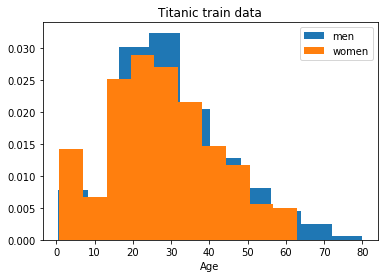

In [18]:
# Age distributions women vs men
fig, axs = plt.subplots(1,1)
axs.hist(train_agedata.loc[train_agedata['Sex']=='male', 'Age'], label='men', density=True)
axs.hist(train_agedata.loc[train_agedata['Sex']=='female', 'Age'], label='women', density=True)
axs.legend()
axs.set_title('Titanic train data')
axs.set_xlabel('Age')
plt.show()

In [19]:
# 2-sample Kolmogorov-Smirnov test to check whether Age distribution between 'male' and 'female' differ
from scipy.stats import ks_2samp
ks_age = ks_2samp(train_agedata.loc[train_agedata['Sex']=='male', 'Age'], train_agedata.loc[train_agedata['Sex']=='female', 'Age'])
print(f'ks stat: {ks_age[0]}; p-value {ks_age[1]}')

ks stat: 0.10380350663520335; p-value 0.0524918961284574


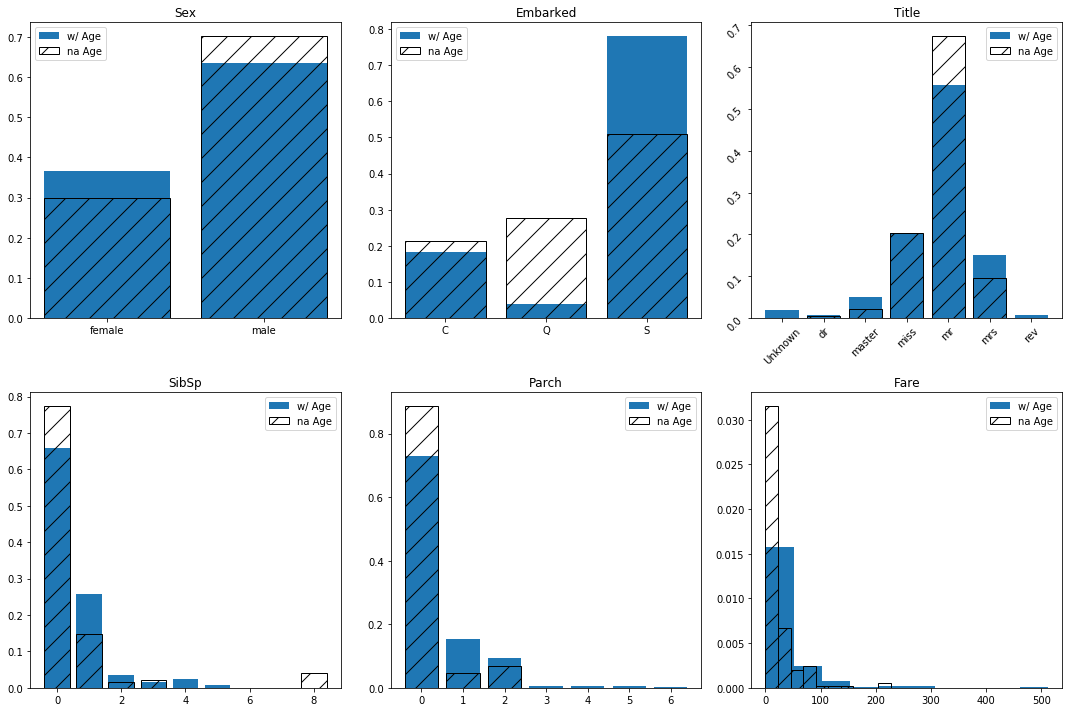

In [20]:
# Plot categorical variables of data w/ Age and with NA Age
fig, axs = plt.subplots(2,3, figsize=(15,10))
i, j = 0, 0
for cat in cat_vars.tolist() + ['SibSp', 'Parch']:
    if cat == 'Ticket':
        continue
    vcount_age = train_agedata[cat].value_counts()
    axs[i,j].bar(vcount_age.index, height=vcount_age/train_agedata.shape[0],
                 label='w/ Age')
    vcount = train_naagedata[cat].value_counts()
    for val in train_agedata[cat].unique():
        if val not in vcount.index:
            vcount[val] = 0
    axs[i,j].bar(vcount.index, height=vcount/train_naagedata.shape[0],
                 fill=False, hatch='/', label='na Age')
    axs[i,j].set_title(cat)
    if cat == 'Title':
        axs[i,j].tick_params(rotation=45)
    axs[i,j].legend()
    if j == 2:
        j=0
        i+=1
    else:
        j+=1
# Handle 'Fare' separately since it's numerical
axs[1,2].hist(train_agedata['Fare'], density=True, label='w/ Age')
axs[1,2].hist(train_naagedata['Fare'], density=True, 
              fill=False, hatch='/', label='na Age')
axs[1,2].legend()
axs[1,2].set_title('Fare')
plt.subplots_adjust(hspace=0.2)
plt.tight_layout()
fig.savefig('naage_vs_age.png')

In [21]:
# Is there are relation between missing age and Sex?
# Run a chi2 test on missing Age data vs Sex
naage_sex = np.column_stack([np.concatenate([train_agedata['Sex'].values, train_naagedata['Sex'].values]),
                 np.r_[np.zeros(shape=(train_agedata.shape[0])), np.ones(shape=(train_naagedata.shape[0]))]])
contingency_tab = pd.crosstab(naage_sex[:,0], naage_sex[:,1])
contingency_tab.columns = ['Age ok', 'NA Age']
print(contingency_tab)
chi2_test = chi2_contingency(contingency_tab)
print(f'chi test statistic {chi2_test[0]:0.5f}, p-value: {chi2_test[1]:0.5f}')
print('p-value < 0.05 do not reject null hypothesis') 
print('missing Age values has no gender bias')

        Age ok  NA Age
row_0                 
female     261      53
male       453     124
chi test statistic 2.43444, p-value: 0.11870
p-value < 0.05 do not reject null hypothesis
missing Age values has no gender bias


In [23]:
# Is there any correlation between port of embarkation and missing age?
# Run a chi2 test on missing Age data vs Embarked
naage_embarked = np.column_stack([np.concatenate([train_agedata['Embarked'].values, train_naagedata['Embarked'].values]),
                 np.r_[np.zeros(shape=(train_agedata.shape[0])), np.ones(shape=(train_naagedata.shape[0]))]])
contingency_tab = pd.crosstab(naage_embarked[:,0], naage_embarked[:,1])
contingency_tab.columns = ['Age ok', 'NA Age']
print(contingency_tab)
chi2_test = chi2_contingency(contingency_tab)
print(f'chi test statistic {chi2_test[0]:0.5f}, p-value: {chi2_test[1]:0.5f}')
print('p-value < 0.05 reject null hypothesis - missing Age values correlates with port of embarkation')

       Age ok  NA Age
row_0                
C         130      38
Q          28      49
S         556      90
chi test statistic 107.75883, p-value: 0.00000
p-value < 0.05 reject null hypothesis - missing Age values correlates with port of embarkation


In [24]:
onehot_agedata = do_onehot(train_agedata)
onehot_naagedata = do_onehot(train_naagedata)

In [25]:
# Impute Age with KNN - test performance on subset with good Age data
def impute_age(indata, k=10, frac=0.15, mode='test'):
    """
    Args:
       indata (DataFrame): input data
       k (int):            k neareast neighbors
       frac (float):       fraction of data to use for testing
       mode (str):         are we testing on imputing unseen data
    
    Returns:
       dict with data, used indices, true_values, rmse
    """
    if mode == 'test':
        test_idx = np.random.choice(indata.index, size=int(indata.shape[0]*frac))
        age_bkp = indata.loc[test_idx, 'Age'].copy(deep=True)
        indata.loc[test_idx, 'Age'] = np.nan
    indata_imputed = pd.DataFrame(knnimpute.knn_impute_reference(indata.values,
                                                                 np.isnan(indata.values), k),
                                 columns=indata.columns, index=indata.index)
    if mode != 'test':
        return {'data': indata_imputed}
    
    indata.loc[test_idx,'Age'] = age_bkp
    rmse = np.mean((indata_imputed.loc[test_idx, 'Age'] - age_bkp)**2)**0.5
    return {'data': indata_imputed, 'test_idx': test_idx, 'orig_age': age_bkp, 'rmse': rmse}

In [26]:
# Test Age imputation with onehot data and k=10...50
rmse_k = {}
for k in range(10, 50):
    imp = impute_age(onehot_agedata, k=k)
    rmse_k[k] = imp['rmse']

In [27]:
# Test Age imputation with categorical age data and k=10...50
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
le_dict = defaultdict(LabelEncoder)
rmse_k_labenc = {}
labenc_agedata = train_agedata.apply(lambda x: le_dict[x.name].fit_transform(x))
for k in range(1, 50):
    imp = impute_age(labenc_agedata, k=k)
    rmse_k_labenc[k] = imp['rmse']

In [28]:
# Impute Age from mean distribution
test_idx = np.random.choice(train_agedata.index, size=int(train_agedata.shape[0]*0.15))
age_bak = train_agedata.loc[test_idx, 'Age'].copy(deep=True)
rmse_mean = np.mean((age_bak - np.mean(train_agedata.loc[~train_agedata.index.isin(test_idx), 'Age']))**2)**0.5


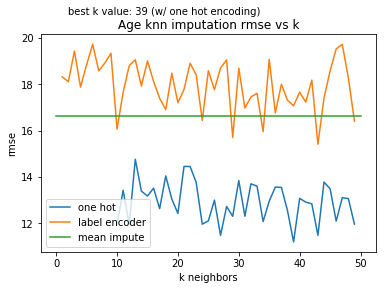

In [29]:
# Plot RMSE vs k values, compare one-hot encoding with simple label encoding
# and with mean value encoding
plt.plot(rmse_k.keys(), rmse_k.values(), label='one hot')
plt.plot(rmse_k_labenc.keys(), rmse_k_labenc.values(), label='label encoder')
plt.plot([0,50], [rmse_mean, rmse_mean], label='mean impute')
best_kval = min(rmse_k, key=rmse_k.get)
plt.text(2, 21, f'best k value: {best_kval} (w/ one hot encoding)')
plt.legend()
plt.title('Age knn imputation rmse vs k')
plt.xlabel('k neighbors')
plt.ylabel('rmse')
plt.savefig('age_impute_knn.png')

In [30]:
# Impute 'Age' with one-hot encoded data with knn and best k
oh_train_data = do_onehot(train_data)
# We can drop the 'Sex_male' column and just keep 'Sex_female'
oh_train_data.drop('Sex_male', axis=1, inplace=True)
print(oh_train_data.columns)
oh_train_data_age_impute = knnimpute.knn_impute_reference(oh_train_data.values,
                                                         np.isnan(oh_train_data.values),
                                                         k=best_kval)
oh_train_data_age_impute = pd.DataFrame(oh_train_data_age_impute, columns=oh_train_data.columns,
                                       index=oh_train_data.index)

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Unknown', 'Title_dr',
       'Title_master', 'Title_miss', 'Title_mr', 'Title_mrs', 'Title_rev'],
      dtype='object')


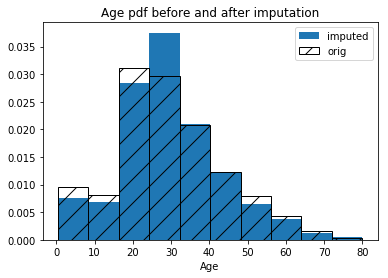

In [31]:
# Compare Age distribution before and after imputation
plt.hist(oh_train_data_age_impute['Age'], density=True, label='imputed')
plt.hist(train_data['Age'].dropna(), density=True, fill=False, hatch='/', label='orig')
plt.xlabel('Age')
plt.title('Age pdf before and after imputation')
plt.legend()
plt.savefig('age_impute.png')

In [32]:
# Run a 2 sample Kolmogorov-Smirnov test 
# to check whether the distributions are similar
age_ks_test = ks_2samp(train_data['Age'].dropna(), oh_train_data_age_impute['Age'])
print(f'KS stat: {age_ks_test[0]:0.6f}, p-value: {age_ks_test[1]:0.6f}')
print('Cannot reject null-hypo, samples come \nfrom same distribution')

KS stat: 0.046766, p-value: 0.343802
Cannot reject null-hypo, samples come 
from same distribution


In [33]:
xgbclf = XGBClassifier()
parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.05, 0.1, 1.0],
              'max_depth': [2,3,4,6],
              'min_child_weight': [5, 7, 9, 11],
              'gamma': [0, 0.5, 1, 3],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7, 1.],
              'n_estimators': [100, 200, 400, 600, 800],
              'missing': [-1],
              'reg_alpha': [0],
              'reg_lambda': [1],
              'seed': [1234]}

clf_age_impute = GridSearchCV(xgbclf, parameters, n_jobs=5,
                              cv=StratifiedKFold(n_splits=5, shuffle=True, 
                                                 random_state=1234), 
                              scoring=['accuracy','roc_auc'],
                              verbose=2, refit='roc_auc',
                              return_train_score=True, iid=False)

clf_age_na = GridSearchCV(xgbclf, parameters, n_jobs=5,
                          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=1234), 
                          scoring=['accuracy','roc_auc'], verbose=2, refit='roc_auc',
                          return_train_score=True, iid=False)

In [ ]:
clf_age_impute.fit(oh_train_data_age_impute.drop('Survived', axis=1), oh_train_data_age_impute['Survived'])

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   19.1s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   33.4s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done 1003 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 1448 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 1975 tasks      | elapsed:  4.5min
[Parallel(n_jobs=5)]: Done 2582 tasks      | elapsed:  5.7min
[Parallel(n_jobs=5)]: Done 3271 tasks      | elapsed:  7.3min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed:  8.9min
[Parallel(n_jobs=5)]: Done 4891 tasks      | elapsed: 10.6min


In [ ]:
oh_train_data.loc[oh_train_data['Age'].isnull(), 'Age'] = -1
clf_age_na.fit(oh_train_data.drop('Survived', axis=1), oh_train_data['Survived'])

In [ ]:
fig, axs = plt.subplots(2,1)
axs[0].plot(clf_age_impute.cv_results_['mean_train_roc_auc'], label='auc - train')
axs[0].plot(clf_age_impute.cv_results_['mean_test_roc_auc'], label='auc - test')
axs[0].legend()
axs[0].set_xlabel('parameter config')
axs[0].set_ylabel('AUC')
axs[0].text(0, 0.95, 'best config {}: {:0.3f}'.format(np.argmax(clf_age_impute.cv_results_['mean_test_roc_auc']),
                                                max(clf_age_impute.cv_results_['mean_test_roc_auc'])))
axs[1].plot(clf_age_impute.cv_results_['mean_train_accuracy'], label='acc. - train')
axs[1].plot(clf_age_impute.cv_results_['mean_test_accuracy'], label='acc. - test')
axs[1].legend()
axs[1].set_ylabel('Acc.')
axs[1].set_xlabel('parameter config')
axs[1].text(0, 0.91, 'best config {}: {:0.3f}'.format(np.argmax(clf_age_impute.cv_results_['mean_test_accuracy']),
                                            max(clf_age_impute.cv_results_['mean_test_accuracy'])))
plt.subplots_adjust(hspace=0.7)
fig.suptitle('One-hot encoded w/ kNN Age imputation')

In [ ]:
fig, axs = plt.subplots(2,1)
axs[0].plot(clf_age_na.cv_results_['mean_train_roc_auc'], label='auc - train')
axs[0].plot(clf_age_na.cv_results_['mean_test_roc_auc'], label='auc - test')
axs[0].legend()
axs[0].set_xlabel('parameter config')
axs[0].set_ylabel('AUC')
axs[0].text(0, 0.95, 'best config {}: {:0.3f}'.format(np.argmax(clf_age_na.cv_results_['mean_test_roc_auc']),
                                                max(clf_age_na.cv_results_['mean_test_roc_auc'])))
axs[1].plot(clf_age_na.cv_results_['mean_train_accuracy'], label='acc. - train')
axs[1].plot(clf_age_na.cv_results_['mean_test_accuracy'], label='acc. - test')
axs[1].legend()
axs[1].set_ylabel('Acc.')
axs[1].set_xlabel('parameter config')
axs[1].text(10, 0.91, 'best config {}: {:0.3f}'.format(np.argmax(clf_age_impute.cv_results_['mean_test_accuracy']),
                                            max(clf_age_impute.cv_results_['mean_test_accuracy'])))
plt.subplots_adjust(hspace=0.7)
fig.suptitle('One-hot encoded w/o Age imputation')

In [ ]:
fold_error = []
results = {}
xgbbest0 = clf_age_impute.best_estimator_
print(xgbbest.get_params)
train_error = np.zeros(shape=(xgbbest.n_estimators,), dtype=np.float32)
train_logloss = np.zeros(shape=(xgbbest.n_estimators,), dtype=np.float32)
test_error = np.zeros(shape=(xgbbest.n_estimators,), dtype=np.float32)
test_logloss = np.zeros(shape=(xgbbest.n_estimators,), dtype=np.float32)
for train_idx, test_idx in clf_age_impute.cv.split(oh_train_data_age_impute.drop('Survived', axis=1), oh_train_data_age_impute['Survived']):
    # get the loss for train and test folds
    eval_set = [(oh_train_data_age_impute.drop('Survived', axis=1).values[train_idx,:],
                oh_train_data_age_impute['Survived'].values[train_idx]),
               (oh_train_data_age_impute.drop('Survived', axis=1).values[test_idx,:],
                oh_train_data_age_impute['Survived'].values[test_idx])]
    xgbbest.fit(oh_train_data_age_impute.drop('Survived', axis=1).values[train_idx,:],
               oh_train_data_age_impute['Survived'].values[train_idx], eval_metric=['logloss', 'error'],
              eval_set=eval_set, verbose=False)
    results = xgbbest.evals_result()
    train_error += np.array(results['validation_0']['error'])
    train_logloss += np.array(results['validation_0']['logloss'])
    test_error += np.array(results['validation_1']['error'])
    test_logloss += np.array(results['validation_1']['logloss'])
    
xgbbest.fit(oh_train_data_age_impute.drop('Survived', axis=1),
               oh_train_data_age_impute['Survived'])


In [ ]:
fig, axs = plt.subplots(1,1)
fig.suptitle('Error on 5 fold splits')
axs.plot(train_error/5, label='train')
axs.plot(test_error/5, label='test')
axs.legend()
axs.set_ylabel('Error')
axs.set_xlabel('Epoch')

In [ ]:
fig, axs = plt.subplots(1,1)
fig.suptitle('Logloss on 5 fold splits')
axs.plot(train_logloss/5, label='train')
axs.plot(test_logloss/5, label='test')
axs.legend()
axs.set_ylabel('Logloss')
axs.set_xlabel('Epoch')

In [ ]:
plot_importance(xgbbest, importance_type='gain')

In [ ]:
# Save model
xgbbest.save_model('titanic_xgbest001.model')

In [ ]:
# Check test data set
titanic_test = pd.read_csv('data/titanic_test.csv')
print(titanic_test.isnull().sum())
print(f'test sample rows {titanic_test.shape[0]}, features {titanic_test.shape[1]}')

In [ ]:
titanic_test.set_index('PassengerId', inplace=True, drop=True)
titanic_test.drop('Cabin', axis=1, inplace=True)
test_naage=titanic_test[titanic_test.loc[:, 'Age'].isnull()].index
titanic_test.loc[titanic_test['Fare'].isnull(), 'Fare'] = train_data['Fare'].mean()

In [ ]:
titanic_test['Title'] = titanic_test.loc[:, 'Name'].apply(get_title)
titanic_test.drop('Name', axis=1, inplace=True)

In [ ]:
# Impute missing 'Age' fields using knn
# Combine NA Age rows of test data with good Age train data
naage_test = titanic_test.loc[titanic_test['Age'].isnull()]
print(naage_test.shape)
oh_naage_test = do_onehot(titanic_test).loc[naage_test.index]
oh_test_age_pre_impute = oh_naage_test.append(onehot_agedata)
print(oh_test_age_pre_impute.shape)

In [ ]:
oh_test_age_impute = knnimpute.knn_impute_reference(oh_test_age_pre_impute.values,
                                                    np.isnan(oh_test_age_pre_impute.values), best_kval)

oh_test_age_impute = pd.DataFrame(oh_test_age_impute, columns=oh_naage_test.columns,
                                  index=np.concatenate([naage_test.index, onehot_agedata.index]))
titanic_test_age_knn_impute = titanic_test.copy(deep=True)
titanic_test_age_knn_impute.loc[naage_test.index, 'Age'] = oh_test_age_impute.loc[naage_test.index, 'Age']
print(titanic_test_age_knn_impute.isnull().sum())

In [ ]:
plt.hist(titanic_test.Age, density=True, label='test')
plt.hist(train_data.Age, density=True, fill=False, hatch='/', label='train')
plt.title('Age distribution')
plt.legend()
plt.xlabel('Age')

In [ ]:
oh_test_data_knn_age = do_onehot(titanic_test_age_knn_impute)
oh_test_data_knn_age.drop('Sex_male', axis=1, inplace=True)

In [ ]:
test_pred = xgbbest.predict_proba(oh_test_data_knn_age.values)
yhat = np.argmax(test_pred, axis=1)

In [ ]:
submission = pd.DataFrame(yhat, index=titanic_test.index, columns=['Survived'])
submission.reset_index(inplace=True)
print(submission)
submission.to_csv('ignacio_xgbtitanic6.csv', index=False)